In [3]:
# Data Wrangling
import pandas as pd
import numpy as np

# Vizualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipeline para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré processamento para incluir no pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler


# modelos
from sklearn.dummy import DummyRegressor # Esse Dummy é o modelo mais simples, a ideia é que os demais passem as metricas apontadas por ele
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output="pandas")

In [4]:
def get_metrics(y_true, y_pred):
  # Função que retorna as metricas de avaliação para esse modelo
  dict_metrics = {
      'R2': metrics.r2_score(y_true, y_pred),
      'MAE': metrics.mean_absolute_error(y_true, y_pred),
      'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
      'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  }
  return dict_metrics

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deploy/Pipelines/data/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='age', ylabel='charges'>

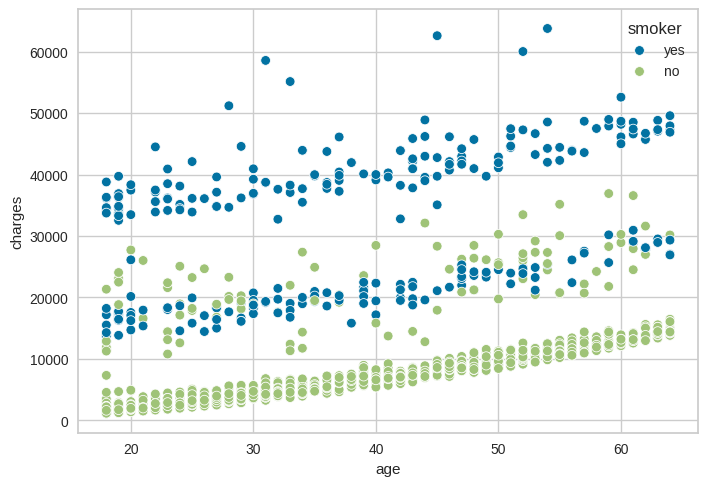

In [8]:
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')

Já podemos ver que ser fumante aumenta considerávelmente o custo de vista

<Axes: xlabel='bmi', ylabel='charges'>

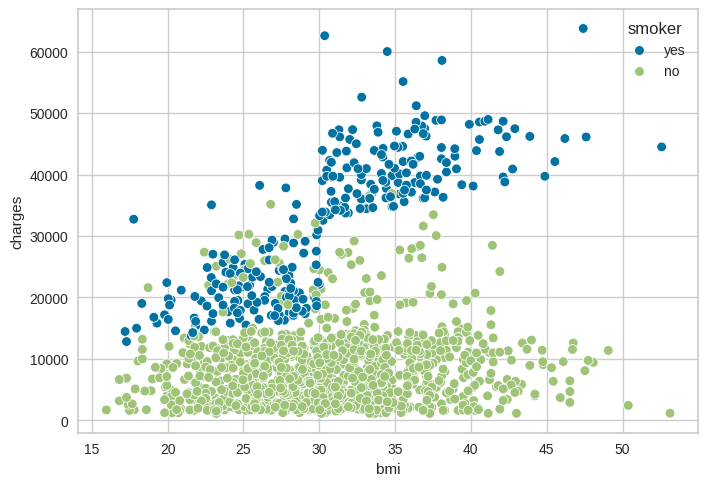

In [9]:
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

novamente o status de fumante está aumentando os valores de massa corporal e o custo consequentemente

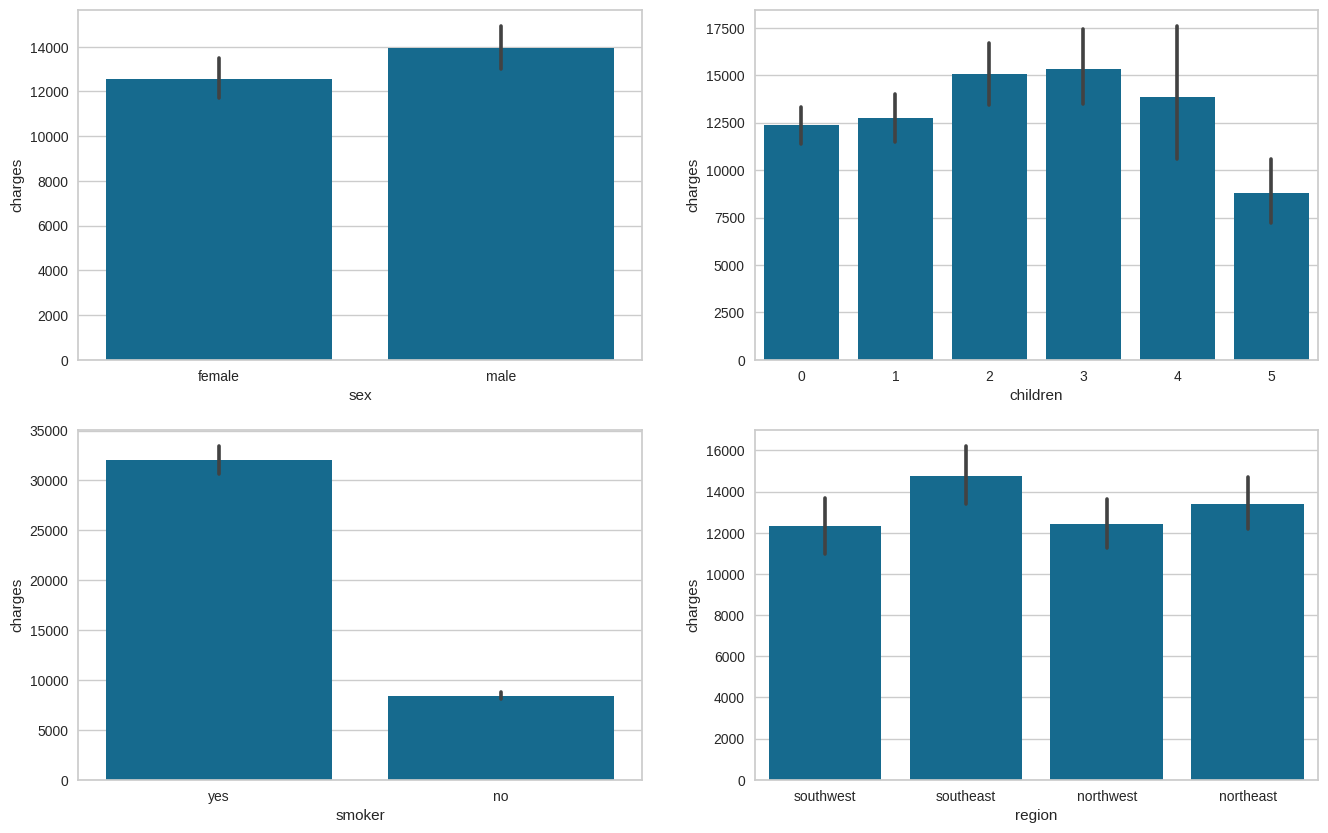

In [13]:
cat_plot_cols = ['sex', 'children', 'smoker', 'region']

f,axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
for col, ax in zip(cat_plot_cols, axes.flatten()):
  sns.barplot(x=col, y='charges', data=df, ax=ax)

<ipython-input-21-6ba1ddcd0d0b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfc = df.corr()


<Axes: >

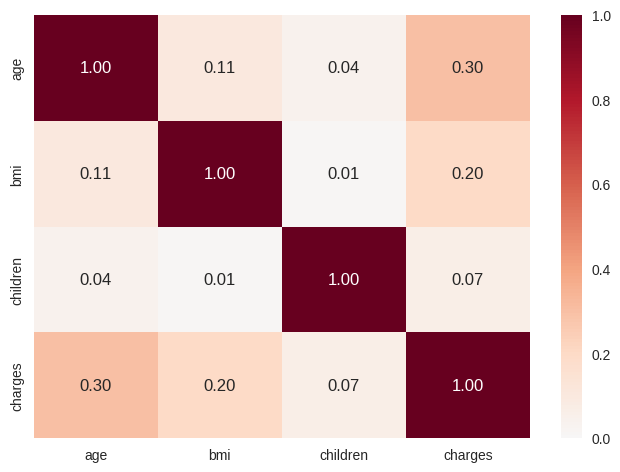

In [21]:
dfc = df.corr()

sns.heatmap(dfc, annot=True, fmt='.2f', center= 0, vmax =1, vmin=0, cmap='RdBu_r')

<Axes: >

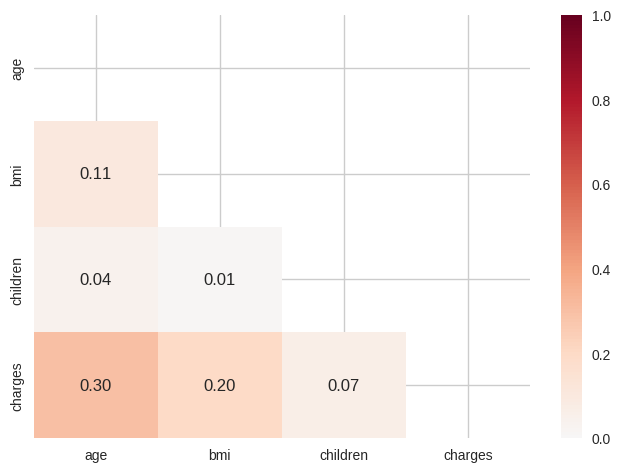

In [24]:
# Montando para não mostrar a linha na transversal
mask = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot=True, fmt='.2f', center= 0, vmax =1, vmin=0, cmap='RdBu_r', mask= mask)
